In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 621.12it/s]


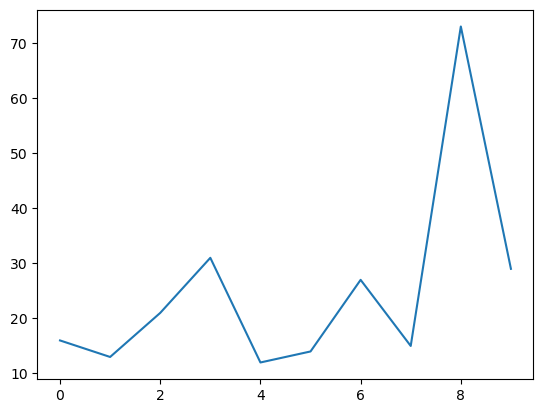

In [2]:
env = gym.make('CartPole-v1')
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# QNetwork

In [3]:
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size = 16, lr = 5e-4, tau = 1e-3) -> None:
        super().__init__()

        self.tau = tau

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        self.criterion = nn.MSELoss()
    
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)
    
    def optimize(self, input, target):
        loss = self.criterion(input, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def sync(self, other_net:nn.Module):
        self.load_state_dict(other_net.state_dict())
        #  for param, other_param in zip(self.parameters(), other_net.parameters()):
        #     param.data.copy_(self.tau*other_param.data + (1.0-self.tau)*param.data)


# Replay Memory

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory():
    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        '''
        @params: 
            batch_size: int
        @return:
            states: torch.tensor
            actions: torch.tensor
            rewards: torch.tensor
            next_states: torch.tensor
            done: torch.tensor
        '''
        if batch_size > len(self.memory): return None
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(batch.state).float()
        next_state_batch = torch.tensor(batch.next_state).float()
        action_batch = torch.tensor(np.vstack(batch.action)).long()
        reward_batch = torch.tensor(np.vstack(batch.reward)).float()
        done_batch = torch.tensor(np.vstack(batch.done)).float()

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

In [5]:
#Test memory
memory = ReplayMemory(capacity=10)
env = gym.make('CartPole-v1')
obs, info = env.reset()
observation_n = len(obs)
action_n = env.action_space.n

for _ in range(10):
    state = env.observation_space.sample()
    next_state = env.observation_space.sample()
    action = env.action_space.sample()
    reward = random.randint(-100,100)
    done = random.choice([True,False])

    memory.push(state, action, reward, next_state, done)

states, actions, rewards, next_states, dones = memory.sample(5)
print(states)
print(actions)
print(rewards)
print(next_states)
print(dones)
env.close()

tensor([[-2.3737e+00, -6.5037e+37, -8.7191e-02,  2.2360e+37],
        [ 4.7664e+00,  9.6248e+37,  2.0337e-01, -2.2398e+38],
        [-1.5758e+00,  6.3962e+37,  3.2065e-01, -2.2668e+38],
        [ 2.3988e+00, -3.0033e+38, -2.1278e-01,  2.3011e+38],
        [ 1.6953e+00,  1.7152e+38, -2.8051e-01, -6.5421e+37]])
tensor([[1],
        [1],
        [1],
        [0],
        [1]])
tensor([[ 36.],
        [ -7.],
        [-30.],
        [ 22.],
        [-71.]])
tensor([[-3.6709e+00,  2.2978e+38, -3.2957e-01,  3.3939e+38],
        [ 1.7877e-01,  2.4956e+38,  4.0526e-01, -1.4602e+38],
        [ 2.3456e+00, -2.7146e+38, -8.2632e-02,  1.8050e+38],
        [-3.1346e+00,  2.6498e+38, -1.6688e-01,  2.9608e+38],
        [ 1.6640e+00, -8.0969e+37, -8.1132e-02, -1.3116e+38]])
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


# Greedy Epsilon

In [26]:
def get_action(state, policy_net, eps, env):
    p = random.random()
    #exploit
    if p > eps:
        policy_net.eval()
        state = torch.tensor(state).float()
        with torch.no_grad():
            action = np.argmax(policy_net(state).cpu().numpy())
        policy_net.train()
        return action
    else:
        return env.action_space.sample()


def epsilon_linear_decay(min_ep, max_ep, decay_ep, epoch, training_epochs):
    return max(min_ep, max_ep * (decay_ep ** epoch))

def plot_epsilon_decay(min_ep, max_ep, decay_ep, training_epochs, epsilon_function):
    eps = []
    for e in range(training_epochs):
        eps.append(epsilon_function(min_ep, max_ep, decay_ep, e, training_epochs))
    sns.lineplot(y = eps, x = list(range(len(eps))))
    plt.show()



In [14]:
env = gym.make('CartPole-v1')
state, info = env.reset()
env = gym.make('CartPole-v1')
obs, info = env.reset()
observation_n = len(obs)
action_n = env.action_space.n

test_net = QNetwork(observation_n, action_n)

exploit = get_action(state, test_net, 0.0, env)
print('exploit = ', exploit)

explore = get_action(state, test_net, 1.0, env)
print('explore = ', explore)
del test_net

exploit =  1
explore =  1


# Plot Epsilon

<Axes: >

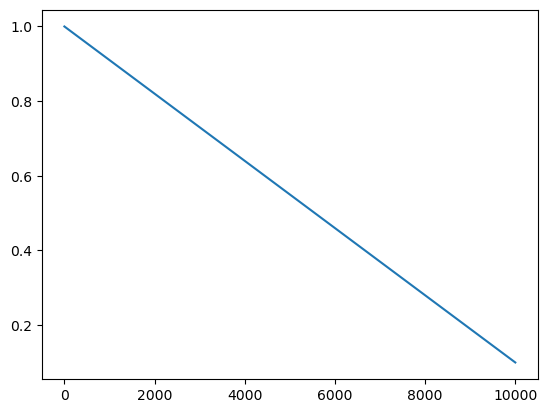

In [16]:
eps = []
min_ep = 0.1
max_ep = 1.0
decay_ep = (max_ep - min_ep) / 1e4
ep = max_ep

for i in range(10000):
    ep = ep - decay_ep
    eps.append(ep)

sns.lineplot(y = eps, x = list(range(len(eps))))

# Output Folder

In [15]:
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output','cartpole')

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

# Training Loop

In [31]:
def tune(hidden_size, memory_cap, batch_size, training_epochs, min_ep, max_ep, decay_ep, epsilon_function, gamma, c, label='default', plot_update_freq = 50): 
    SAVE_PATH = os.path.join(OUTPUT, label)

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    env = gym.make('CartPole-v1')
    obs,info = env.reset()
    state_size = len(obs)
    action_size = env.action_space.n

    # agent = Agent(state_size, action_size)
    policy_net = QNetwork(state_size, action_size, hidden_size=hidden_size)
    target_net = QNetwork(state_size, action_size, hidden_size=hidden_size)

    memory = ReplayMemory(capacity=memory_cap)

    scores = []
    score_window = deque(maxlen = 100)

    # epsilon = max_ep

    step_count = 0
    sync_count = 0

    loop = tqdm(range(training_epochs))
    history = defaultdict(list)
    best_avg_reward = 0

    for epoch in loop:

        state, info = env.reset(seed = 0)
        total_reward = 0
        done = False
        epsilon = epsilon_function(min_ep, max_ep, decay_ep, epoch, training_epochs)

        for t in count():

            step_count += 1

            action = get_action(state, policy_net, epsilon, env)
            next_state, reward, terminated, truncated, info = env.step(action)

            total_reward += reward

            if terminated or truncated:
                done = True

            memory.push(state, action, reward, next_state, done)

            state = next_state

            transitions = memory.sample(batch_size)

            if transitions != None:
                states, actions, rewards, next_states, dones = transitions

                next_state_values = target_net(next_states).detach().max(1)[0].unsqueeze(1)
                ### Calculate target value from bellman equation
                # NOTE: make sure that next state values has shape (batch_size, 1)
                # or loss function can't optimize properly
                next_state_values = rewards + gamma * next_state_values * (1 - dones)
                # print('q target = ', q_targets.shape)
                ### Calculate expected value from local network
                state_values = policy_net(states).gather(1, actions)

                policy_net.optimize(state_values, next_state_values)

                
                if step_count % c == 0:
                    target_net.sync(policy_net)
                    sync_count += 1
            if done:
                break

        avg_reward = np.mean(score_window)
        score_window.append(total_reward)
        
        #stop if avg reward > 250
        # if avg_reward >= 250:
        #     break
        if best_avg_reward <= avg_reward:
            best_avg_reward = avg_reward
            #save best model
            torch.save(policy_net, os.path.join(SAVE_PATH, 'policy_net.checkpoint.torch'))
            torch.save(target_net, os.path.join(SAVE_PATH, 'target_net.checkpoint.torch'))


        loop.set_description(f'epsilon = {epsilon:.2f}, avg rewards={avg_reward:.2f}, best_avg_reward={best_avg_reward:.2f}, memory_len = {len(memory.memory)}')
        history['reward'].append(np.mean(score_window))
        history['epsilon'].append(epsilon)
        fig_save_path = os.path.join(SAVE_PATH, 'plot.png')

        if epoch % plot_update_freq == 0:
            plot(history, save_path = fig_save_path)

    torch.save(policy_net, os.path.join(SAVE_PATH, 'policy_net.final.torch'))
    torch.save(target_net, os.path.join(SAVE_PATH, 'target_net.final.torch'))

    plot(history, show = True)

def plot(history, show = False, save_path = None):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))), ax = ax1)
    ax1.set_title('100-iteration average reward per epoch')
    sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))), ax = ax2)
    ax2.set_title(label = 'epsilon decay')

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()


# Solved, DO NOT DELETE

In [ ]:
training_epochs = 2000
max_ep = 1.0
min_ep = 0.1
decay_ep =0.999
seed = 0

hidden_size = 16
memory_cap = int(5e5)
batch_size = 32

lr = 1e-3
gamma = 0.99
tau = 1e-3
c = 4
plot_epsilon_decay(min_ep, max_ep, decay_ep, training_epochs, epsilon_linear_decay)

# plot_epsilon_decay(min_ep, max_ep, decay_ep, training_epochs, epsilon_linear_decay)
tune(hidden_size, memory_cap, batch_size, training_epochs, min_ep, max_ep, decay_ep, epsilon_linear_decay ,gamma,c, label = 'baseline')

# Run the final agent

ep = 99, reward = 500.0: 100%|██████████| 100/100 [00:02<00:00, 36.91it/s]


<Axes: >

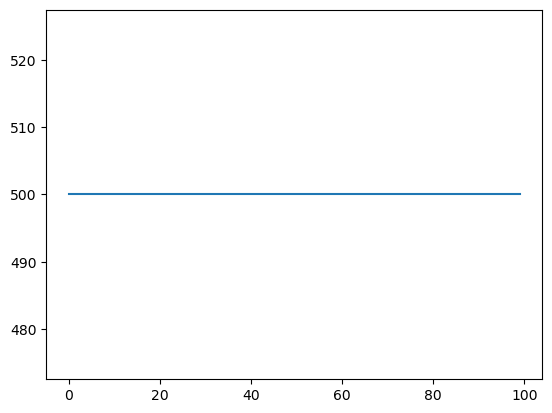

In [41]:
# nv = gym.make('CartPole-v1')
env = gym.make('CartPole-v1')
rewards = []

# net = torch.load('best_target_net.torch')
net = torch.load(os.path.join(OUTPUT, 'baseline_best', 'policy_net.checkpoint.torch'))

loop = tqdm(range(100))
for epoch in loop:
    state, info = env.reset()
    state = torch.tensor(state, dtype = torch.float32).unsqueeze(0)

    total_reward = 0
    for step in count():
        action = get_action(state, net, 0.0, env)
        next_state, reward, terminated, truncated, info = env.step(action.item())
        next_state = torch.tensor(next_state, dtype = torch.float32).unsqueeze(0)
        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    loop.set_description(f'ep = {epoch}, reward = {total_reward}')
    rewards.append(total_reward)
    
sns.lineplot(y = total_reward, x= list(range(len(rewards))))